In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from stop_words import get_stop_words
import string
from wordcloud import WordCloud
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import TruncatedSVD
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, auc
from sklearn.pipeline import Pipeline, FeatureUnion

In [9]:
plt.rcParams['text.color'] = 'black'
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [10]:
# needed for tokenization
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# You need the averaged_perceptron_tagger resource to determine the context of a word in a sentence.

[nltk_data] Downloading package punkt to /Users/nohossat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nohossat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
df = pd.read_csv("booking_comments.csv", na_values=[''], decimal=',', encoding="utf8", escapechar='\\')

## Exploration des données

In [12]:
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,NaN,NaN,0.0,None,NaN,NaN,NaN,NaN,Hôtel,Paris,8.2
1,Guillaume,France,0.0,2019-06-21 00:00:00,Superbe,Ce client n'a pas laissé de commentaire.,None,8.8,Hôtel,Cannes,7.1
2,Isabelle,France,0,2019-09-09 00:00:00,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0,Hôtel,Nantes,8.0
3,Laura,France,0.0,2019-03-01 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,None,7.9,Appart'hôtel,Cannes,6.6
4,Anonyme,France,0.0,2019-06-07 00:00:00,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0,Hôtel,Paris,7.6


In [13]:
#dimensions du dataframe
print(f'Le dataset a {df.shape[0]} lignes et {df.shape[1]} colonnes.')
print('')
#affichage des variables
print(f'Les différents variables sont : ')

for col in df.columns.values:
    print(f'- {col}')

Le dataset a 50814 lignes et 11 colonnes.

Les différents variables sont : 
- nom
- pays
- favorite
- date
- titre
- bons_points
- mauvais_points
- note
- type_etablissement
- lieu
- note_etablissement


### Statistiques descriptives

In [14]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,50070,50072,50786,50814,50072,50107,50422,50064.000000,50814,50814,50814.000000
unique,9367,144,4,1236,14383,25710,28948,NaN,12,6,NaN
top,Anonyme,France,0.0,None,Passable,Ce client n'a pas laissé de commentaire.,None,NaN,Hôtel,Paris,NaN
freq,5023,43017,29267,743,5547,11838,18208,NaN,42688,25396,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.497633,NaN,NaN,7.693083
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.277708,NaN,NaN,0.908541
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,3.900000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.600000,NaN,NaN,7.200000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.200000,NaN,NaN,7.900000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.800000,NaN,NaN,8.300000


## Sélection des variables

Dans notre analyse, on partira sur deux hypothèses pour déterminer la polarité des commentaires:  
   - calcul de la polarité des commentaires récoltés
   - utilisation de la colonne note pour déterminer la polarité
    
On conservera donc toutes les variables qui constituent le commentaire final et la note associée.

In [15]:
data = df.drop(['nom', 'pays', 'favorite', 'date', 'type_etablissement', 'lieu', 'note_etablissement'], axis= 1)

data.head()

,titre,bons_points,mauvais_points,note
0,NaN,NaN,NaN,NaN
1,Superbe,Ce client n'a pas laissé de commentaire.,None,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,petit déjeuner très peu de choix et servis jus...,"Dans la chambre un éclairage plus tamisé,dans ...",5.0
3,Bien,Ce client n'a pas laissé de commentaire.,None,7.9
4,Bien,La baignoire sur pieds dans la chambre.. comme...,Le rapport qualité/prix.. Mais bon Paris est P...,7.0


## Traitement des valeurs manquantes

In [16]:
data.isna().sum()

titre             742
bons_points       707
mauvais_points    392
note              750
dtype: int64

In [17]:
# we delete empty rows
data = data.dropna(how='all')

# we delete the rows where the note is null - have to be careful with this
# since we have 2 hypothesis that we want to test and removing 1202 rows over 80k we still have plenty of data
data = data.loc[data.note.notna()]

# we replace None and none values by empty strings
data = data.replace(['None', 'none'], '')

# in the titre, bons_points and mauvais points columns we replace nan by empty strings
data = data.fillna('')

data.isna().sum()

titre             0
bons_points       0
mauvais_points    0
note              0
dtype: int64

In [18]:
# replace automatic comments by booking by empty strings
commentaires_booking = ["Ce commentaire n'apparaît pas car il ne respecte pas notre charte.", "Ce client n'a pas laissé de commentaire."]
# mask = (data.bons_points.isin(commentaires_booking))|(data.mauvais_points.isin(commentaires_booking))
# data = data.loc[~mask]
data.bons_points.loc[data.bons_points.isin(commentaires_booking)] = ''
data.mauvais_points.loc[data.mauvais_points.isin(commentaires_booking)] = ''
data.shape

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(50064, 4)

## Concaténation des colonnes Titre, Bons Points et Mauvais Points

In [19]:
# merge columns
data['review'] = data.titre + ' ' + data.bons_points + ' ' + data.mauvais_points
data = data[['review', 'note']]
data

,review,note
1,Superbe,8.8
2,Déçu par rapport aux descriptifs je ne recomma...,5.0
3,Bien,7.9
4,Bien La baignoire sur pieds dans la chambre.....,7.0
5,Pas content ! Pas grand-chose !\nLit assez con...,4.0
...,...,...
50808,"Bon acceuil, très bon rapport qualité, prix! B...",10.0
50809,Fabuleux Hôtel proche de la Gare Montparnasse...,9.2
50811,Un séjour médiocre La localisation et le perso...,4.0
50812,Arrivé le soir à 22h30 et reparti le lendemain...,9.2


## Proportion de commentaires positifs / négatifs

Pour éviter d'avoir un modèle biaisé, on va observer si les commentaires sont équilibrés en fonction de leur note

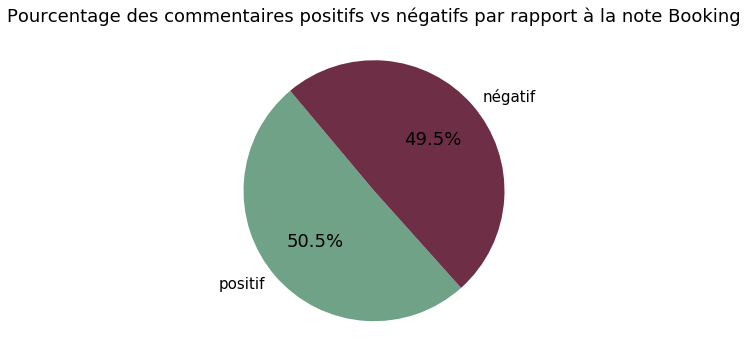

In [20]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = data.note.groupby(data.note > 6).size() / data.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs par rapport à la note Booking", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

## Comment préparer son dataset dans un projet NLP ?

Pour optimiser notre modélisation, on souhaite **conserver seulement les mots / caractères les plus pertinents pour déterminer la polarité d'un commentaire**. 

Il y a deux approches : 
- découpage par mot
- découpage par groupe de mots (bag of words)



## Première approche : découpage par mot

Pour ce faire, on va passer par 3 étapes :

- tokenisation
- retrait des stop words
- normalization avec le procédé de stemming

### 1 - Tokenisation

Pour faciliter la compréhension du language naturel par la machine, on doit transformer nos chaînes de caractères en tokens.

>**tokens** : mots, ponctuation, symboles

La tokenisation basique consiste à séparer le texte par les espaces et la ponctuation. 

In [21]:
get_review_tokens = (word_tokenize(review) for review in data.review)

### 2 - retrait des stop words

Les conjonctions de coordinations et la ponctuation n'apporte pas d'information pertinente donc pour améliorer la vitesse du modèle on peut les retirer et éviter d'influencer le modèle par leur présence, on les retire.

In [22]:
def remove_stopwords(commentaire):
    # remove stop words from the review
    stop_words = get_stop_words('french')  
    stop_words.remove(['ne', 'pas']) #prendre en compte ces 2 caractères
    
    # remove punctuation
    ponctuations = string.punctuation
    
    #remove ellipsis
    p = re.compile(r'\.+')
    
    # remove stop words, ellipsis, punctuation and words which length is below 2, numbers
    commentaire = [p.sub(r'', word) for word in commentaire if word.lower() not in stop_words and word not in ponctuations and not word.isnumeric() and len(word) > 2]
    
    return ' '.join(commentaire)

In [23]:
cleaned_review_tokens = [remove_stopwords(review) for review in get_review_tokens]

ValueError: list.remove(x): x not in list

### 3 - Lexicon Normalization : Stemming & Lemmatization

La normalisation en NLP consiste à conserver la forme canonique des mots du corpus. On peut utiliser deux méthodes : le stemming et la lemmatization. 

La lemmatization consiste à analyser le mot selon le contexte d'utilisation et le remplacer par une forme normalisée.

#### Lemmatization - CHANGER VARIABLES

In [ ]:
lemmatizer = FrenchLefffLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

df['sentence'].apply(lambda x : word_lemmatizer(x))

#### Stemming

Pour éviter d'inclure les variations d'un mot dans notre corpus (ex: vouloir : veux, voulons, veuille, etc..), on va récuperer le radical du mot.

In [ ]:
def stem_review(review):
    stem = FrenchStemmer()
    review = review.split(' ')
    return [stem.stem(word) for word in review]

In [ ]:
normalized_tokens = [stem_review(review) for review in cleaned_review_tokens]

>On obtient les tokens nettoyés et normalisés par commentaire.

## Fréquence et nuage des mots

Pour observer la fréquence des mots, on va utiliser le corpus **cleaned_review_tokens** qui ne comprend pas la normalization et donc nous permet de voir les mots dans leur forme entière.

In [ ]:
# we need to get all words
all_words = np.array(cleaned_review_tokens).flatten()
all_words = ' '.join(all_words).split() 

#calculer les 100 mots les plus fréquents
nb = 100
word_dist = nltk.FreqDist(all_words)

In [ ]:
#affichage dans un dataframe des 7 mots les plus fréquents
word_frequency = pd.DataFrame(word_dist.most_common(nb), columns=['Word', 'Frequency'])
most_frequent = word_frequency.head(10)
most_frequent

In [ ]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.barplot(x="Word",y="Frequency", data=most_frequent)

In [ ]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [ ]:
wcloud(all_words,'black','Common Words')

## Analyse de sentiments

L'analyse de sentiments consiste à déterminer si un commentaire est positif, neutre ou négatif.

### Première approche : utilisation de la note Client

Avec les notes Booking, on va faire la répartition suivante : 

0 => 5 : négatif  
sup 5 : positif  

#### Dataset 1

In [ ]:
X = np.array([' '.join(review) for review in normalized_tokens])

In [ ]:
notes_booking = data.note.copy()
notes_booking.loc[notes_booking < 5] = 0
notes_booking.loc[notes_booking >= 5] = 1

In [ ]:
# récupération du dataset pour l'inclure à l'application Flask
dataset_note_booking = pd.DataFrame(data= {'sentence' : X, 'polarite' : notes_booking})
dataset_note_booking.to_csv('dataset_booking_model.csv', index=False)

### Deuxième approche : Calcul de la polarité

On va utiliser le Pattern Analyzer de textBlob pour déterminer la polarité d'un commentaire

Une polarité de : 
* \- 1 à 0 exclus : commentaire négatif
* 0 : commentaire neutre
* 0 exclus à 1 : commentaire positif

La polarité, on va la calculer sur les tokens sans stemming pour avoir des résultats corrects soit sur **cleaned_review_tokens**

In [ ]:
# sentiment renvoie un tuple avec la polarité et la subjectivite, on veut récuperer juste la première valeur
polarite = [TextBlob(review, analyzer=PatternAnalyzer()).sentiment[0] for review in cleaned_review_tokens]

#### Dataset 2

In [ ]:
dataset_with_polarite = pd.DataFrame({'sentance': X, 'polarite' : polarite})

la polarité peut prendre une valeur continue entre -1 et 1 donc on va regrouper les valeurs en 2 groupes (0 / 1)
et supprimer les commentaires neutres

In [ ]:
dataset_polarite_binary = dataset_with_polarite.loc[dataset_with_polarite['polarite'] != 0]
dataset_polarite_binary.loc[dataset_polarite_binary['polarite'] < 0] = 0
dataset_polarite_binary.loc[dataset_polarite_binary['polarite'] > 0] = 1

In [32]:
# récupération du dataset avec la polarite pour l'inclure à l'application Flask
dataset_polarite_binary.to_csv('dataset_polarite.csv', index=False)

In [7]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = dataset_polarite_binary.polarite.groupby(dataset_polarite_binary.polarite > 1).size() / dataset_polarite_binary.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs par rapport à la polarié", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

NameError: name 'dataset_polarite_binary' is not defined

>est-ce que la polarité calculée et les notes sont corrélées ?
si oui, on peut utiliser la note booking comme target par exemple

### Corrélation entre les notes Booking et la polarité calculée

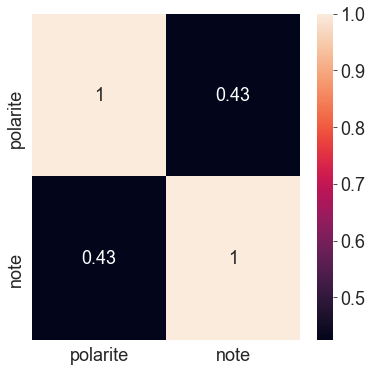

In [33]:
d = {'polarite': polarite, 'note': notes_booking.values}
polarites = pd.DataFrame(data=d)

df_corr = polarites.corr()
sns.heatmap(df_corr, annot=True)

## Analyse comparative des modèles de classification

On va tester plusieurs modèles pour voir celui qui nous sort les meilleurs résultats : 
   - Régression logistique
   - Naive Bayes : ComplementNB, Multinomial
   - Méthodes ensemblistes : XGB, GradientBoosting, RandomForest
   - SVM

### Feature Transformation - A TERMINER

Il faut transformer nos features en données numériques pour qu'elles soient acceptées par les différents modèles que l'on souhaite tester.

Il y a plusieurs méthodes que l'on peut utiliser: 

#### Count Vectorizer

Convert a collection of text documents to a matrix of token counts

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

#### Tf-idf Transformer

Compared to a Count Vectorizer, which just counts the number of occurrences of each word, Tf-Idf takes into account the frequency of a word in a document, weighted by how frequently it appears in the entire corpus.

#### N-gram

TBD

#### Truncated SVD

CountVectorizer de Scikit-learn est utilisé pour transformer un corpus de mots en vecteurs/occurence des mots 

- obtenir l'occurence des mots dans chaque review (Count Vectorizer) - A BIEN EXPLIQUER
- TFIDTransformer : The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

XGBoost  

XGBoost stands for eXtreme Gradient Boosting and is an implementation of gradient boosting machines that pushes the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed. Specifically, it was engineered to exploit every bit of memory and hardware resources for the boosting. XGBoost offers several advanced features for model tuning, computing environments and algorithm enhancement. It is capable of performing the three main forms of gradient boosting (Gradient Boosting (GB), Stochastic GB and Regularized GB) and it is robust enough to support fine tuning and addition of regularization parameters.

### Fonction de modélisation

In [34]:
def run_model(db_name, model_name, feat_trans_name, model, X_train, y_train, params=None, random_state=None):
    # measures the time taken by the model to run
    start_time = time.time()
    
    # run a grid search if params set
    if params :
        clf = GridSearchCV(model(), params, cv = 5, n_jobs = 6)
    else :
        if random_state:
            clf = model(random_state=random_state)
        else:
            clf = model()
        best_params = None
    
    clf.fit(X_train, y_train)
    
    if params:
         best_params = clf.best_params_
            
    y_pred = clf.predict(X_train)
    
    # we will record some metrics in a CSV file for presentation
    
    # metrics
    model_fit = clf
    duration = time.time() - start_time
    accuracy = np.mean(cross_val_score(clf, X_train, y_train, cv=5)) # avg score on the CV
    precision = precision_score(y_train, y_pred, average=None)
    recall = recall_score(y_train, y_pred, average=None)
    f1score = f1_score(y_train, y_pred, average=None)
    results = [[db_name, model_name, feat_trans_name, accuracy, precision, recall, f1score, model_fit, best_params, duration ]]
    
    # save to csv
    cols = ['dataset', 'model_name', 'feature transformation', 'accuracy', 'precision', 'recall', 'f1_score', 'model_fit' ,'best paramaters', 'duration']
    
    try:
        backup = pd.read_csv('booking_models_metrics.csv')
    except:
        backup = pd.DataFrame([], columns=cols)
    
    model_metrics = pd.DataFrame(results, columns=cols)
    
    backup = pd.concat([backup, model_metrics])
    backup.to_csv('booking_models_metrics.csv', index=False)
    
    return backup

## Fonction pour obtenir une analyse comparative pour un dataset donné

In [50]:
def get_models_result(name_dataset, dataset):
    # get split data
    X = dataset['sentence']
    y = dataset['polarite']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # get different types of X_train according to feature transformation
    train_data = {}
    
    # CountVectorizer + Tf-idf
    pipe_tfidf = make_pipeline(CountVectorizer(), TfidfTransformer())
    X_train_tfidf = pipe_tfidf.fit_transform(X_train).toarray()
    train_data['CV + TF-IDF'] = X_train_tfidf
    
    print(train_data['CV + TF-IDF'].shape)
    
    # CountVectorizer + N-gram
    pipe_ngram = make_pipeline(CountVectorizer(min_df=0.0005, ngram_range=(1, 2)), TfidfTransformer())
    X_train_ngram = pipe_ngram.fit_transform(X_train).toarray()
    train_data['CV(n-gram) + TF-IDF'] = X_train_ngram
    
    print(train_data['CV(n-gram) + TF-IDF'].shape)
    # memory error with n-gram, so i have to fix this first
    
    # CountVectorizer + Tf-idf Truncated SVD
    pipe_svd_tfidf = make_pipeline(CountVectorizer(), TfidfTransformer(), TruncatedSVD(n_components=300))
    X_train_svd = pipe_svd_tfidf.fit_transform(X_train)
    train_data['CV + TF-IDF + SVD'] = X_train_svd
    
    print(train_data['CV + TF-IDF + SVD'].shape)
    
    # list models
    models = {
        'NB - ComplementNB': ComplementNB,
        'NB - Multinomial' : MultinomialNB,
        'SVC' : SVC,
        'XGB': XGBClassifier,
        'Gradient Boosting' : GradientBoostingClassifier,
        'Random Forest' : RandomForestClassifier,
        'AdaBoost': AdaBoostClassifier
    }
    
    # related params for GridSearch and random_state
    params = {
        'NB - ComplementNB': [None, None],
        'NB - Multinomial' : [None, None],
        'SVC' : [ { 'C': [10,100],
                 'kernel': ['rbf','sigmoid'], 
                 'gamma' : ['scale', 'auto']},
                 0 ],
        'XGB': [ { 'max_depth' : [3, 10],
                 'n_jobs' : 6},
                0],
        'Gradient Boosting' : [ {'min_samples_split' : [40],
                                  'min_samples_leaf' : [40], 
                                 'max_depth' : [3]}, 0], 
        'Random Forest' : [{'min_samples_split' : [10, 20],
                                  'min_samples_leaf' : [10, 40], 
                                 'max_depth' : [3, 10]}, 0],
        
        'AdaBoostClassifier' : [ {'base_estimator' : [MultinomialNB, SVC],
                                  'n_estimators' : [50, 100]}, 
                                0]
    }
    
    # run models with different parameters and different feature extraction methods
    for name_model, model in models.items():
        for name_X_train, X_train in train_data.items():
            print(name_dataset, name_model, name_X_train, params[name_model][0], params[name_model][1])
            try : 
                run_model(name_dataset, name_model, name_X_train, model, X_train, y_train, params=params[name_model][0], random_state=params[name_model][1])
            except Exception as e:
                print(e)
            print('done')
        

In [51]:
get_models_result('note booking', dataset_note_booking)

(40051, 15843)
(40051, 4581)
(40051, 300)
note booking NB - ComplementNB CV + TF-IDF None None
done
note booking NB - ComplementNB CV(n-gram) + TF-IDF None None
done
note booking NB - ComplementNB CV + TF-IDF + SVD None None
Negative values in data passed to ComplementNB (input X)
done
note booking NB - Multinomial CV + TF-IDF None None
done
note booking NB - Multinomial CV(n-gram) + TF-IDF None None
done
note booking NB - Multinomial CV + TF-IDF + SVD None None
Negative values in data passed to MultinomialNB (input X)
done
note booking SVC CV + TF-IDF {'C': [10, 100], 'kernel': ['rbf', 'sigmoid'], 'gamma': ['scale', 'auto']} 0


KeyboardInterrupt: 

In [52]:
def get_tokens(review):
    review_words = word_tokenize(review)
    
    # remove punctuation
    ponctuations = string.punctuation
    #remove ellipsis
    p = re.compile(r'\.+')
    
    review_words = [p.sub(r'', word) for word in review_words if word not in ponctuations and not word.isnumeric() and len(word) > 2]
    
    # stemming
    stem = FrenchStemmer()
    review_words = [stem.stem(word) for word in review_words]
    return review_words

def run_model():
    stop_words = get_stop_words('french') 
    
    classifier = Pipeline([
    ('features', FeatureUnion([
        ('only tfidf', Pipeline([
            ('cv', )
            ('tfidf', TfidfVectorizer(tokenizer=get_tokens, stop_words=stop_words,
                     min_df=.0025)),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('tfidf + ngram', Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=get_tokens, stop_words=stop_words,
                     min_df=.0025, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('tfidf + svd', Pipeline([
            ('tfidf', TfidfVectorizer(tokenizer=get_tokens, stop_words=stop_words,
                     min_df=.0025, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ]))
    ])),
    ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
#    ('clf', RandomForestClassifier()),
    ])
    
    classifier.fit(X_train, y_train)
    
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'pca__n_components': [5, 15, 30, 45, 64],
        'logistic__C': np.logspace(-4, 4, 4),
    }
    
    grid_clf = GridSearchCV(classifier, param_grid, n_jobs=-1)
    grid_clf.fit(X_train, y_train)
    

Concatenates results of multiple transformer objects.

This estimator applies a list of transformer objects in parallel to the input data, then concatenates the results. This is useful to combine several feature extraction mechanisms into a single transformer.


In [ ]:

union = FeatureUnion([("pca", PCA(n_components=1)),
                    ("svd", TruncatedSVD(n_components=2))])

In [ ]:
get_models_result('polarite', dataset_polarite_binary)

In [ ]:
# all models and params

# list models
    models = {
        'Gradient Boosting ' : GradientBoostingClassifier,
        'Random Forest' : RandomForestClassifier,
        'XGB': XGBClassifier,
        'SVC' : SVC,
        'AdaBoost': AdaBoostClassifier
    }
    
    # related params for GridSearch and random_state
    params = {
        'Gradient Boosting ' : [ {'min_samples_split' : [10, 20, 50],
                                  'min_samples_leaf' : [10, 40], 
                                 'max_depth' : [3, 10, 15]}, 0], 
        'Random Forest' : [{'min_samples_split' : [10, 20, 50],
                                  'min_samples_leaf' : [10, 40], 
                                 'max_depth' : [3, 10, 15]}, 0],
        'XGB': [0, 0],
        'SVC' : [{ 'C': [10,100],
                 'kernel': ['rbf','sigmoid']}, 
                 0],
        'AdaBoostClassifier' : [ {'base_estimator' : [MultinomialNB, SVC],
                                  'n_estimators' : [50, 100, 200]}, 
                                0]
    }

## Résultats

dataset des résultats

## Limites des modèles

- sarcastique
- 